# Evaluating speech polarization over time

In [1]:
PATH = "/home/piotr/projects/twitter"
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import gc
import json
import pickle
from datetime import datetime, timedelta
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import random
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import itertools
from functools import partial
import os
import ast
import pdb
import sys
sys.path.append(os.path.join(PATH, 'src'))
from twitter_models.polarization import ModelPolarization
from twitter_tools.utils import read_files, clean_tweets, filter_data
from twitter_tools.evaluation import polarization as evaluation
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import logging
import statsmodels.api as sm
import nltk

In [6]:
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        word = line.strip('\n')
        if word != 'nie':
            stopwords.append(word)
stopwords.append('mieć')
PATH_DROP = os.path.join(PATH, 'results/cleaning/DROP_IDS.json')
START = '2020_02_23'
END = '2020_07_15'
dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))
topic_map = json.load(open(os.path.join(PATH, 'results/topics/mallet/topic_map.json'), 'r'))
topic_dict = json.load(open(os.path.join(PATH, 'results/topics/mallet/lda_20.json'), 'r'))
#topic_map = {k:topic_dict[str(v)] for k, v in topic_map.items()} #convert to text topic labels

In [3]:
gov = pickle.load(open(os.path.join(PATH, 'data/sample/gov_sample.p'),"rb"))
opp = pickle.load(open(os.path.join(PATH, 'data/sample/opp_sample.p'),"rb"))
parties = {k:"gov" for k in gov}
parties.update({k:"opp" for k in opp})
PATH_DATA = os.path.join(PATH, "data/clean")


#Get random assignment
random_keys = list(parties.keys()); random.shuffle(random_keys) #randomize keys
random_values = list(parties.values()); random.shuffle(random_values) #randomize values
randomized = dict(zip(random_keys, random_values)) #zip into dict

The call below writes a new file that contains data from the day-level files filtered using the data filtering function defined above:

In [66]:
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))

#filter function:
def filter_fun(df:pd.DataFrame, drop_users:list, drop_tweets:list):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    df.drop_duplicates(inplace = True, subset = ['lemmatized'])
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets)

def weighted_average(group, weight_name, ):
    weights = group['n']
    score = group['score']   
    return np.average(score,weights=weights)

*The leave-out estimator of partisanship is obtained using the following process. Each user's speech-generating process is assumed to follow a multinomial distribution over the possible phrase set, where each phrase is picked with a certain choice probability. The*


\begin{equation}
\hat{\pi}_{t}^{LO} = \frac{1}{2} \frac{1}{|R_{t}|} \sum_{i \in R_{t}} \hat{q}_{i,t}  \cdot \hat{p}_{-i,t} +  \frac{1}{2} \frac{1}{|D_{t}|} \sum_{i \in D_{t}} \hat{q}_{i,t}  \cdot (1 - \hat{p}_{-i,t})\\
\end{equation}


$\hat{p}_{-i,t} = \hat{q}_{-i,t}^{R} / (\hat{q}_{-i,t}^{R} + \hat{q}_{-,it}^{D})$ is the probability of an observer with a neutral prior assigning a speaker to government based only on a given phrase



$\hat{q}_{i,t} = c_{i,t} / m_{i,t}$ are the phrase frequencies for speaker $i$ at time $t$ 




*The estimation of confidence interval for the leave-out estimator is obtained via sub-sampling, using the procedure described by Gentzkow et al. (2019), based on Politis et al. (1990) procedure. Specifically:*

(THE CI FORMULA GOES HERE)

# 1. Partisanship over time - day level

### 1.1 Overall partisanship
- using all data
- excluding duplicated Tweets

#### Day-level estimates: 

In [5]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col = 0)
else:
    results = defaultdict(lambda: dict().fromkeys(["true","random"])) #store for each day
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day]["true"] = model.estimate(parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day]["random"] = model.estimate(random_parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)
    results = dict(results) #convert defaultdict to dict
    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                                  for i in results.keys() 
                                  for j in results[i].keys()}, orient = 'index')
    results.to_csv(PATH_RESULTS)

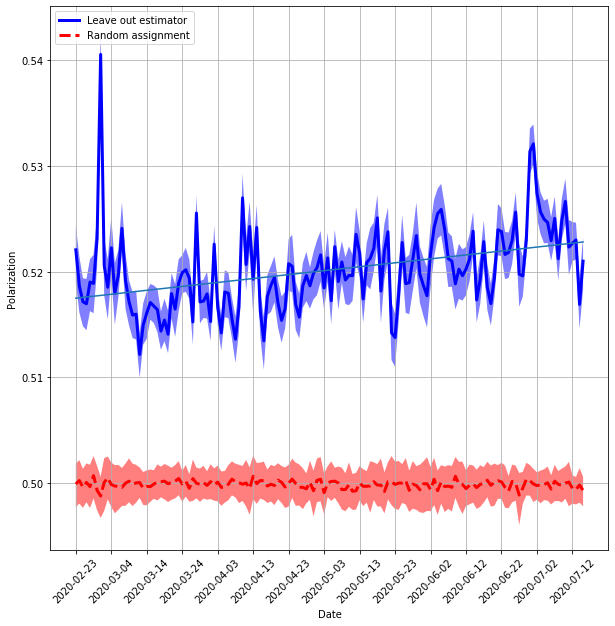

In [68]:
evaluation.plot_aggregated(results, trend_line = True)

#### Day-level smoothed estimates
To obtained "smoother" version of the daily the estimates, I use rolling-window of 7 days to compute the vocabulary on which the estimates are based. For example, the "smoothed" estimate for 5th of March uses the vocabulary between the 2th and 8th of March to fit the ngram tokenizer, and then only phrases used on the 5th to compute the polarization on that particular day.

In [33]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily_window.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS)
else:
    results = defaultdict(dict) #store results
    fmt = '%Y_%m_%d' #date formatting for files
    START2 = (datetime.strptime(START, fmt) + timedelta(days = 7)).strftime(fmt)
    reader = partial(read_files, path = PATH_DATA, day_to = END, dtype = dtypes, filter_fun = ff)
    reader_weekly = reader(day_from = START, batch_size = 7)
    reader_daily = reader(day_from = START2, batch_size = 1)
    data = next(reader_weekly) #get first week
    data['day'] = pd.to_datetime(data['day']) #convert to datetime
    for df in tqdm(reader_daily):
        df['day'] = pd.to_datetime(df['day'])
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = logging.INFO)
        model.prefit(data["lemmatized"].astype(str).to_numpy())
        #fit only for the middle date from the window
        window = data['day'].unique() #current window
        mid_date = sorted(window)[3] #get middle entry
        data_mid = data[data['day'] == mid_date]
        mid_date_str = np.datetime_as_string(mid_date, unit = 'D') #convert to string for key
        results[mid_date_str]['true'] = model.estimate(data_mid['source'], 
                                                         data_mid['user-id_str'], 
                                                         data_mid['lemmatized'], 
                                                         level = 'aggregate',
                                                         conf_int = 100)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = logging.INFO)
        model.prefit(data["lemmatized"].astype(str).to_numpy())
        random_parties = data_mid["user-id_str"].astype(str).map(randomized)
        results[mid_date_str]['random'] = model.estimate(random_parties, 
                                                     data_mid['user-id_str'], 
                                                     data_mid['lemmatized'], 
                                                     level = 'aggregate',
                                                     conf_int = 100)

        data = data[data.day != data.day.min()] #filter out oldest day
        data = data.append(df)

    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                                  for i in results.keys() 
                                  for j in results[i].keys()}, orient = 'index')
    results.index.names = ['date','type']
    results.to_csv(PATH_RESULTS)

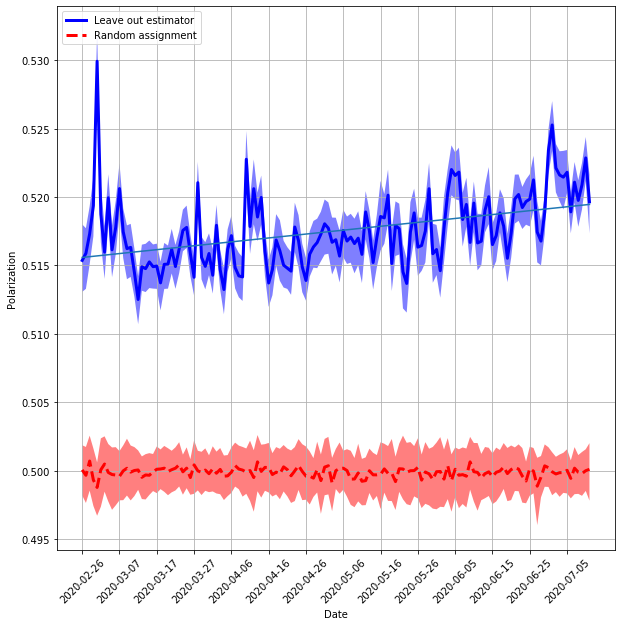

In [34]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, trend_line = True, tick_freq = 10)
plt.show()

### 1.2 Within-topics partisanship, based on the LDA-Mallet topic model

#### Day-level estimates of topic partisanship

In [59]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily_topics.csv")
if os.path.isfile(PATH_RESULTS):
    part_within = pd.read_csv(PATH_RESULTS, index_col = 0)
else:
    part_within = dict()
    for df in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, batch_size = 1, 
                                dtype = dtypes, filter_fun = ff)):
        
        df['topic'] = df['id_str'].astype(str).map(topic_map)
        #fit vectorizer on all vocabulary:
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = 20)
        _ = model._vectorize_text(df["lemmatized"].astype(str).to_numpy())
        del _
        gc.collect()
        
        #iterate over each topic:
        for k in sorted(df['topic'].unique()):
            data = df.loc[df['topic'] == k]
            parties = data["source"] #get parties 
            users = data["user-id_str"] #get users 
            tweets = data["lemmatized"].astype(str) #get tweets
            day = data['day'].unique()[0]
            try:
                part_within[(k, day)] = model.estimate(parties, users, tweets, level = "aggregate", conf_int = None)
            except:
                continue
    part_within = pd.DataFrame.from_dict(part_within, orient = 'index')

    part_within.index.names = ['topic','date']
    part_within.reset_index(inplace = True)
    part_within[['gov','opp']] = pd.json_normalize(part_within['n'])
    del part_within['n']
    part_within.set_index(['topic','date'], inplace = True)
    part_within['n'] = part_within['gov'] + part_within['opp']
    part_within.to_csv(PATH_RESULTS)

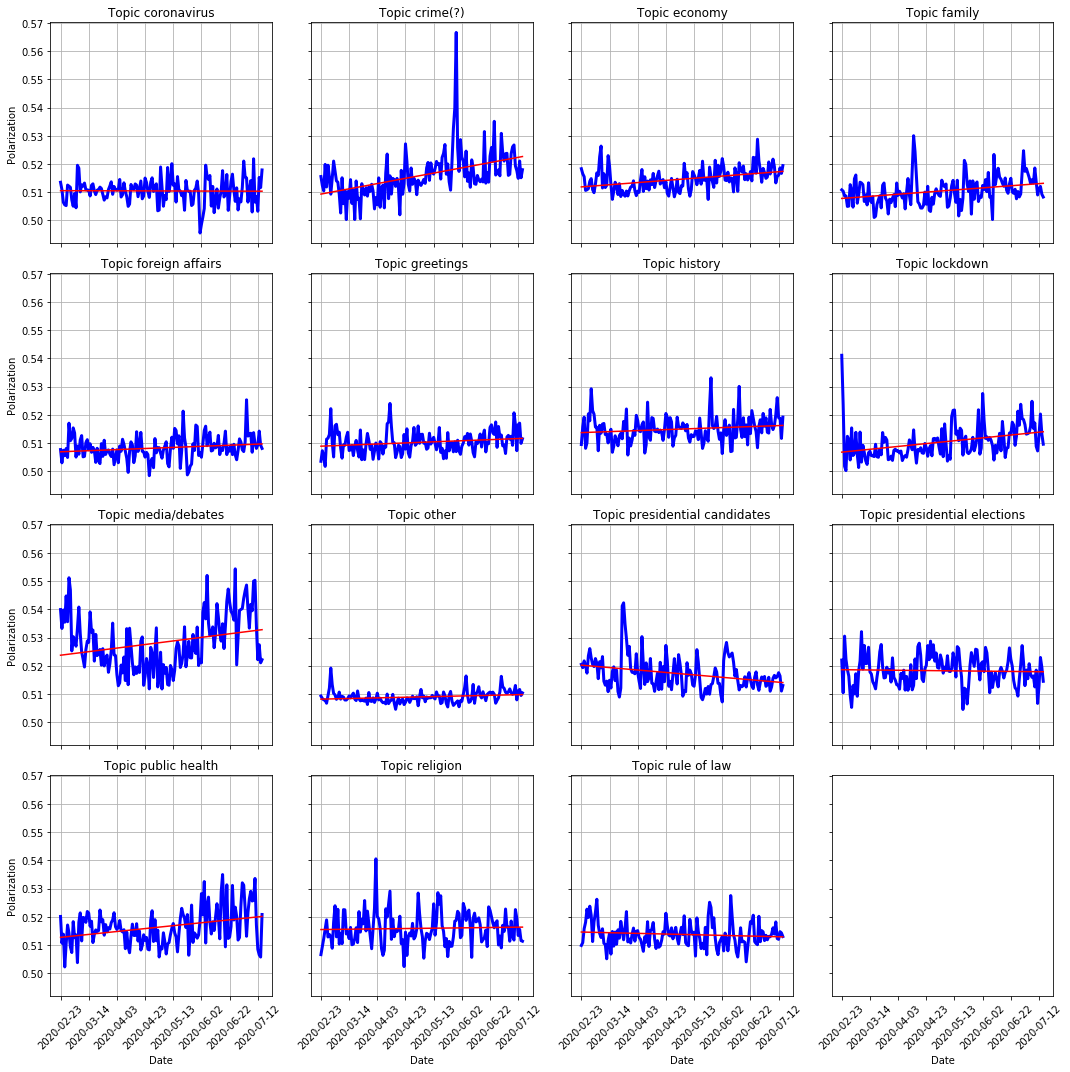

In [32]:
part_within = part_within.reset_index()
evaluation.plot_aggregated_bytopic(part_within.date, part_within.point, part_within.topic, figsize = (15, 15), trend_line = True)

#### Polarization autocorrelation within each topic:
To examine the presence of the trend, I have also plotted the autocorrelation of each topic-polarization time series for 20 lags.

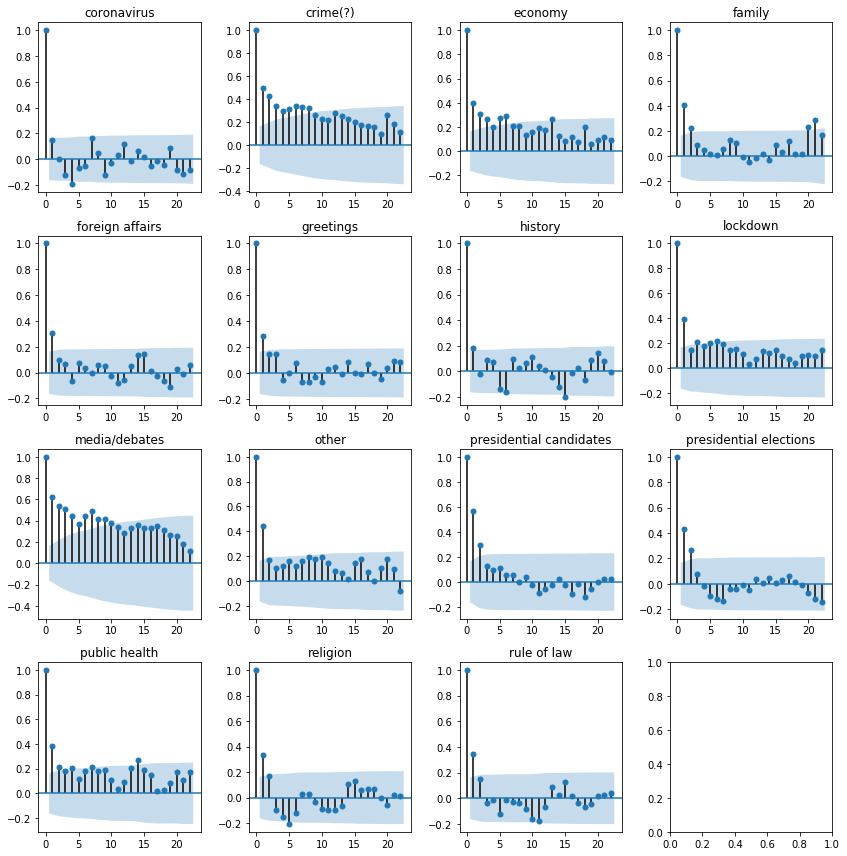

In [34]:
ntopics = part_within['topic'].unique().size
side = int(np.ceil(np.sqrt(ntopics)))
fig, ax = plt.subplots(side, side, figsize = (12, 12))
ax = ax.ravel()
for i, (topic, df) in enumerate(part_within.groupby('topic')):
    plot_acf(df['point'], ax = ax[i])
    ax[i].set_title(f'{topic}')
plt.tight_layout()
plt.show()

#### Linear fits:
To further investigates trends within each of the topics, I fitted an OLS regression for each of them, and examined the slope and the intercept.

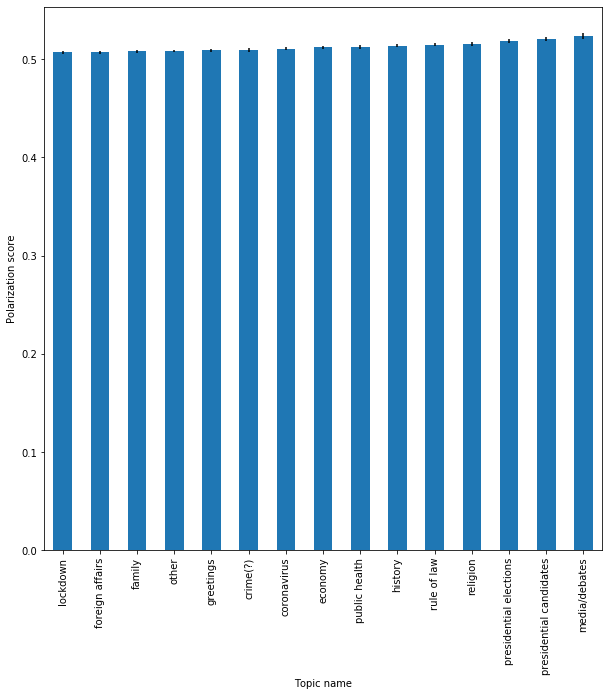

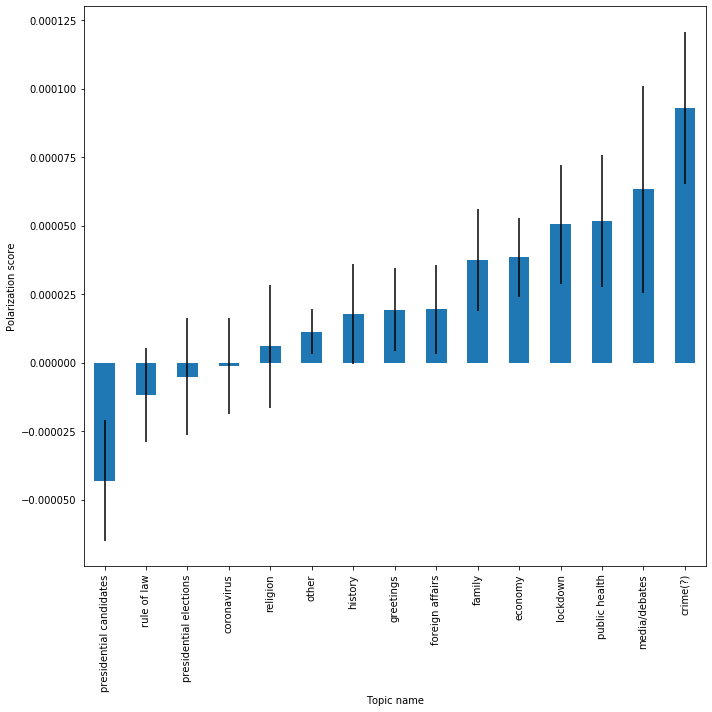

In [35]:
fits = pd.DataFrame(columns = ['lower','upper', 'point','topic'])
date_num = np.arange(len(np.unique(part_within.reset_index().date)))
X = sm.add_constant(date_num)
for topic, df in part_within.groupby('topic'):
    model = sm.OLS(df['point'], X)
    fit = model.fit()
    res = fit.conf_int()
    res.columns = ['lower','upper']
    res['point'] = fit.params
    res['topic'] = topic
    fits = fits.append(res)
fits.set_index('topic', inplace = True, append = True)
fits.index.names = ['coef','topic']
fits = fits.reset_index()
fits['err'] = fits['upper'] - fits['point']
axes = fits.reset_index().sort_values('point').groupby(['coef']).plot.bar('topic','point',figsize = (10, 10), yerr = 'err')
for ax in axes:
    ax.get_legend().remove()
    #ax.set_xticklabels(fits['topic'].unique(), rotation = 45)
    ax.set_ylabel('Polarization score')
    ax.set_xlabel('Topic name')
plt.tight_layout()
plt.show()

### 1.3.  Between-topic partisanship:
I then proceed to compute the daily polarization between topics. The **between-topic** polarization estimate, is defined as the expected posterior probability of assigning a speech to the correct party, assuming the observer knows only the topic, i.e. disregarding the content of the tweets. This allows to evaluate the level of polarization determined only by the topics chosen by the partisans, not by the phrases they use to discuss them.

In [38]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily_between_topics.csv")
if os.path.isfile(PATH_RESULTS):
    part_between = pd.read_csv(PATH_RESULTS, index_col = 0)['score']
else:
    part_between = dict()
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff)):
        parties = data["source"] #get parties 
        topics = data['id_str'].astype(str).map(topic_map)
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        part_between[day] = model.estimate_topics(parties, topics)
    part_between = pd.DataFrame.from_dict(part_between, orient = 'index')
    part_between.columns = ['score']
    part_between = part_between['score']
    part_between.to_csv(PATH_RESULTS)

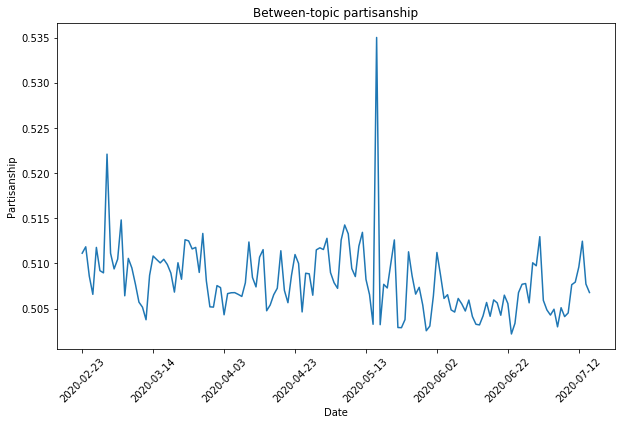

In [39]:
part_between.plot(rot = 45, figsize = (10, 6), legend = False, title = 'Between-topic partisanship')
plt.xlabel('Date')
plt.ylabel('Partisanship')
plt.show()

### 1.4. Comparison of partisanship:

Following Gentzkow et al., to decompose the sources of polarization I calculate **within-topic** polarization as an average of the polarization within each of the identified topic, weighted by the total number of users tweeting on the topic on a given day. I then compare it with the **between-topic** polarization obtained in the previous section. This decomposition provides a way of determining to what extent is the change in polarization over time driven by the difference in which partisans tweet on the same topic vs. the difference in topics on which they tweet.

In [40]:
PATH_BETWEEN = os.path.join(PATH, "results/polarization/polarization_daily_between_topics.csv")
PATH_WITHIN = os.path.join(PATH, "results/polarization/polarization_daily_topics.csv")
PATH_OVERALL = os.path.join(PATH, "results/polarization/polarization_daily.csv")

#BETWEEN PARTISANSHIP
part_between = pd.read_csv(PATH_BETWEEN, index_col = 0)['score']

#WITHIN PARTISANSHIP:
part_within = pd.read_csv(PATH_WITHIN, index_col = 0)
part_within = part_within.reset_index().groupby('date').apply(lambda x: np.average(x['point'], weights = x['n']))

#OVERALL PARTISANSHIP:
part_overall = pd.read_csv(PATH_OVERALL, index_col = 0)
part_overall = part_overall[part_overall['type'] == 'true'].set_index('date')['estimate']

#COMBINE:
part = pd.DataFrame(dict(within = part_within, between = part_between, overall = part_overall))

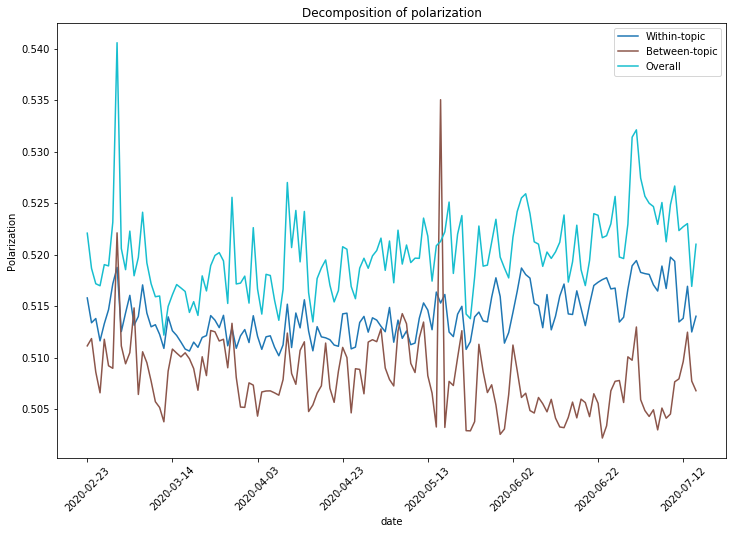

In [41]:
part.plot(figsize = (12, 8), rot = 45, title = 'Decomposition of polarization',  cmap = 'tab10')
plt.ylabel('Polarization')
plt.legend(['Within-topic', 'Between-topic', 'Overall'])
plt.show()

The level of partisanship seems to have increased in the topics of presidential candidates, finance, media and decreased in political parties, coronavirus, and elections. 

## 2 Week level estimates
To compare the trend visible in the estimates, I also compute the polarization on a weekly level, i.e. for all tweets in a 7-day window.

### 2.1 Overall

In [18]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_weekly.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS)
else:
    results = dict() #store for each day
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, batch_size = 7, 
                                dtype = dtypes, filter_fun = ff)):
        #get period:
        dates = pd.to_datetime(data.day)
        date_min = dates.min().strftime('%d/%m')
        date_max = dates.max().strftime('%d/%m')
        week = date_min + '-' + date_max
        
        #fit model
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[(week, "true")] = model.estimate(parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)

        #fit randomized model:
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 50, ngram_range = (1,2))
        results[(week, "random")] = model.estimate(random_parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)
    results = dict(results) #convert defaultdict to dict
    results = pd.DataFrame.from_dict(results, orient = 'index')
    results.columns = ['date','type','lower_ci','upper_ci','estimate']
    results.to_csv(PATH_RESULTS)

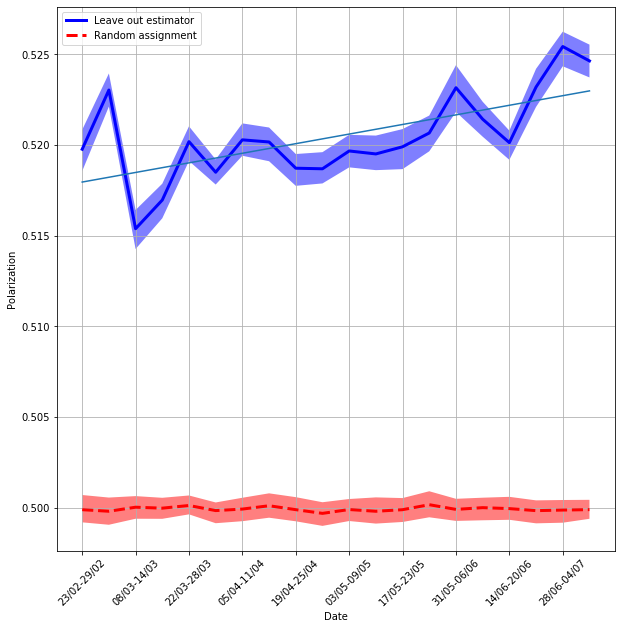

In [19]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, trend_line = True, tick_freq = 2)
plt.show()

### 2.2 Within topics:

In [ ]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_weekly_topics.csv")
if os.path.isfile(PATH_RESULTS):
    part_within = pd.read_csv(PATH_RESULTS, index_col = 0)
else:
    part_within = dict()
    for df in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, batch_size = 7, 
                                dtype = dtypes, filter_fun = ff)):
        
        df['topic'] = df['id_str'].astype(str).map(topic_map)
        #fit vectorizer on all vocabulary:
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = 20)
        _ = model._vectorize_text(df["lemmatized"].astype(str).to_numpy())
        del _
        gc.collect()
        
        #iterate over each topic:
        for k in sorted(df['topic'].unique()):
            data = df.loc[df['topic'] == k]
            parties = data["source"] #get parties 
            users = data["user-id_str"] #get users 
            tweets = data["lemmatized"].astype(str) #get tweets
            
                    #get period:
            dates = pd.to_datetime(data.day)
            date_min = dates.min().strftime('%d/%m')
            date_max = dates.max().strftime('%d/%m')
            week = date_min + '-' + date_max
            try:
                part_within[(k, week)] = model.estimate(parties, users, 
                                                        tweets, level = "aggregate", 
                                                        conf_int = 100)
            except:
                continue
    part_within = pd.DataFrame.from_dict(part_within, orient = 'index')

    part_within.index.names = ['topic','date']
    part_within.reset_index(inplace = True)
    part_within[['gov','opp']] = pd.json_normalize(part_within['n'])
    del part_within['n']
    part_within.set_index(['topic','date'], inplace = True)
    part_within['n'] = part_within['gov'] + part_within['opp']
    part_within.to_csv(PATH_RESULTS)

### 2.3 Between topics:

In [ ]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_weekly_between_topics.csv")
if os.path.isfile(PATH_RESULTS):
    part_between = pd.read_csv(PATH_RESULTS, index_col = 0)['score']
else:
    part_between = dict()
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, 
                                dtype = dtypes, filter_fun = ff, batch_size = 7)):
        parties = data["source"] #get parties 
        topics = data['id_str'].astype(str).map(topic_map)
        #get period:
        dates = pd.to_datetime(data.day)
        date_min = dates.min().strftime('%d/%m')
        date_max = dates.max().strftime('%d/%m')
        week = date_min + '-' + date_max
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        part_between[week] = model.estimate_topics(parties, topics)
    part_between = pd.DataFrame.from_dict(part_between, orient = 'index')
    part_between.columns = ['score']
    part_between = part_between['score']
    part_between.to_csv(PATH_RESULTS)

### 2.4 Comparison:

In [ ]:
PATH_BETWEEN = os.path.join(PATH, "results/polarization/polarization_weekly_between_topics.csv")
PATH_WITHIN = os.path.join(PATH, "results/polarization/polarization_weekly_topics.csv")
PATH_OVERALL = os.path.join(PATH, "results/polarization/polarization_weekly.csv")

#BETWEEN PARTISANSHIP
part_between = pd.read_csv(PATH_BETWEEN, index_col = 0)['score']

#WITHIN PARTISANSHIP:
part_within = pd.read_csv(PATH_WITHIN, index_col = 0)
part_within = part_within.reset_index().groupby('date').apply(lambda x: np.average(x['point'], weights = x['n']))

#OVERALL PARTISANSHIP:
part_overall = pd.read_csv(PATH_OVERALL, index_col = 0)
part_overall = part_overall[part_overall['type'] == 'true'].set_index('date')['estimate']

#COMBINE:
part = pd.DataFrame(dict(within = part_within, between = part_between, overall = part_overall))

In [ ]:
part.plot(figsize = (12, 8), rot = 45, title = 'Decomposition of polarization',  cmap = 'tab10')
plt.ylabel('Polarization')
plt.legend(['Within-topic', 'Between-topic', 'Overall'])
plt.show()

# 3. Phrase partisanship
To evaluate the partisanship of particular phrases, I obtained the posterior probability pf a phrase being assigned to the government by an observer with neutral prior based on the Gentzkow model. I then looked at phrases which occured on at least 115 days (i.e. less than 40 days missingness), and examined phrases with highest government partisanship (i.e. posterior close to 1), opposition partisanship (i.e. posterior close to 0) and highest variation in partisanship over time.

In [43]:
PATH_RES = os.path.join(PATH, 'results/polarization/phrase_partisanship.csv')
if os.path.isfile(PATH_RES):
    phrases = pd.read_csv(PATH_RES, index_col = 'date')
else:
    phrases = dict()
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        phrases[day] = model.get_posteriors(parties, users, tweets)
    phrases = pd.DataFrame.from_dict(phrases).reset_index().melt('index')
    phrases.columns = ['phrase','date','posterior']
    phrases = phrases.set_index(['date'])
    phrases.to_csv(PATH_RES)

In [44]:
phrases = phrases[np.logical_not(phrases.phrase.isin(stopwords))]
summary = phrases.groupby('phrase').agg({'posterior':[np.mean, np.std, lambda x: x.isna().sum()]})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['posterior_mean','posterior_sd','posterior_miss']

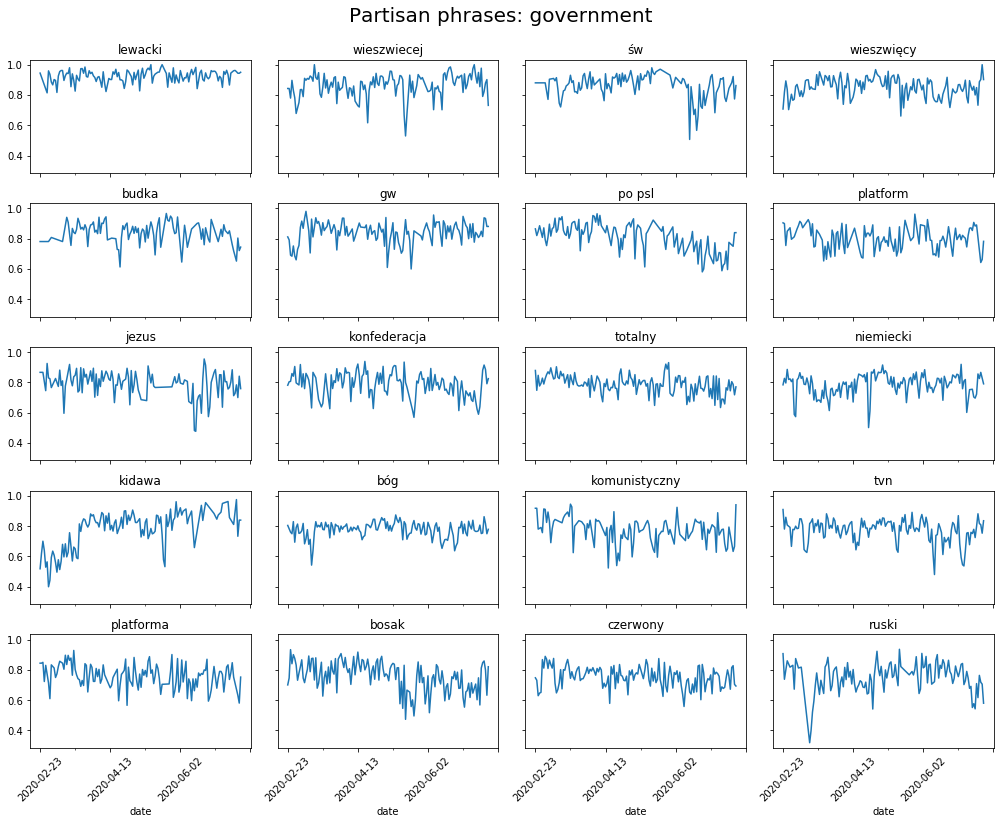

In [13]:
phrases_gov = summary[summary.posterior_miss < 40].sort_values(['posterior_mean'], ascending = False).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize = (14, 12), sharex = True, sharey = True)
fig.suptitle('Partisan phrases: government', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_gov.phrase):
    phrases[phrases.phrase == phr].posterior.interpolate(method = 'linear',limit_direction = 'both').plot(rot = 45, ax = ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

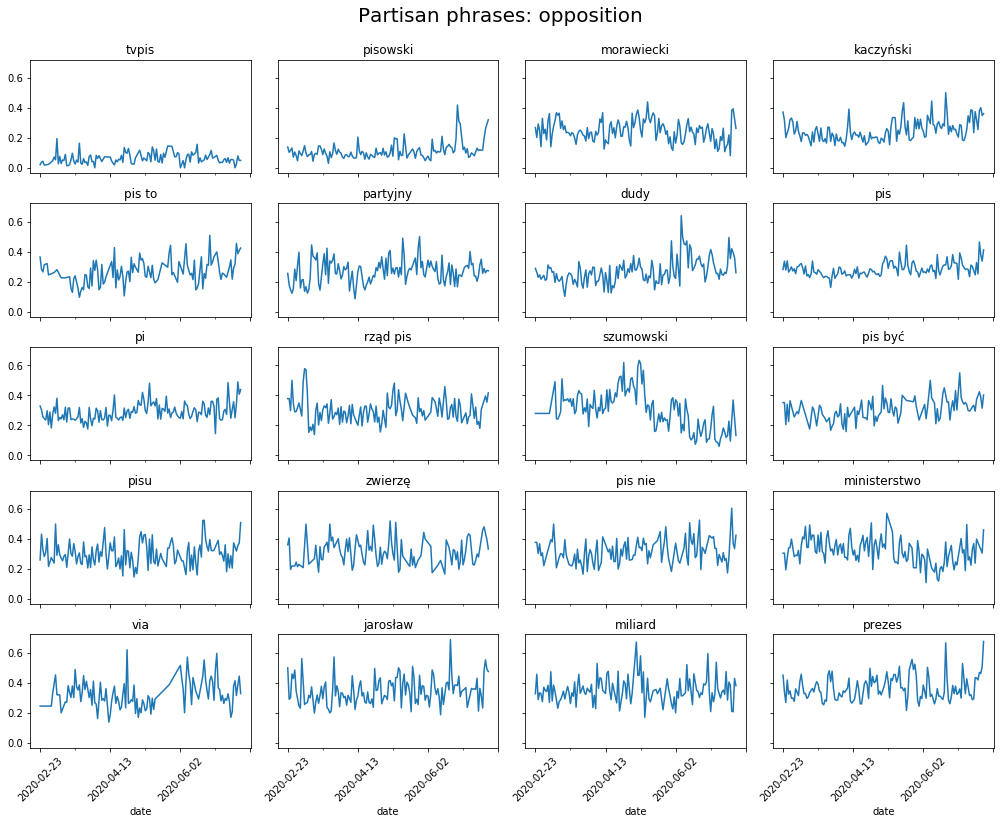

In [14]:
phrases_opp = summary[summary.posterior_miss < 40].sort_values(['posterior_mean'], ascending = True).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize = (14, 12), sharex = True, sharey = True)
fig.suptitle('Partisan phrases: opposition', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_opp.phrase):
    phrases[phrases.phrase == phr].posterior.interpolate(method = 'linear',limit_direction = 'both').plot(rot = 45, ax = ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

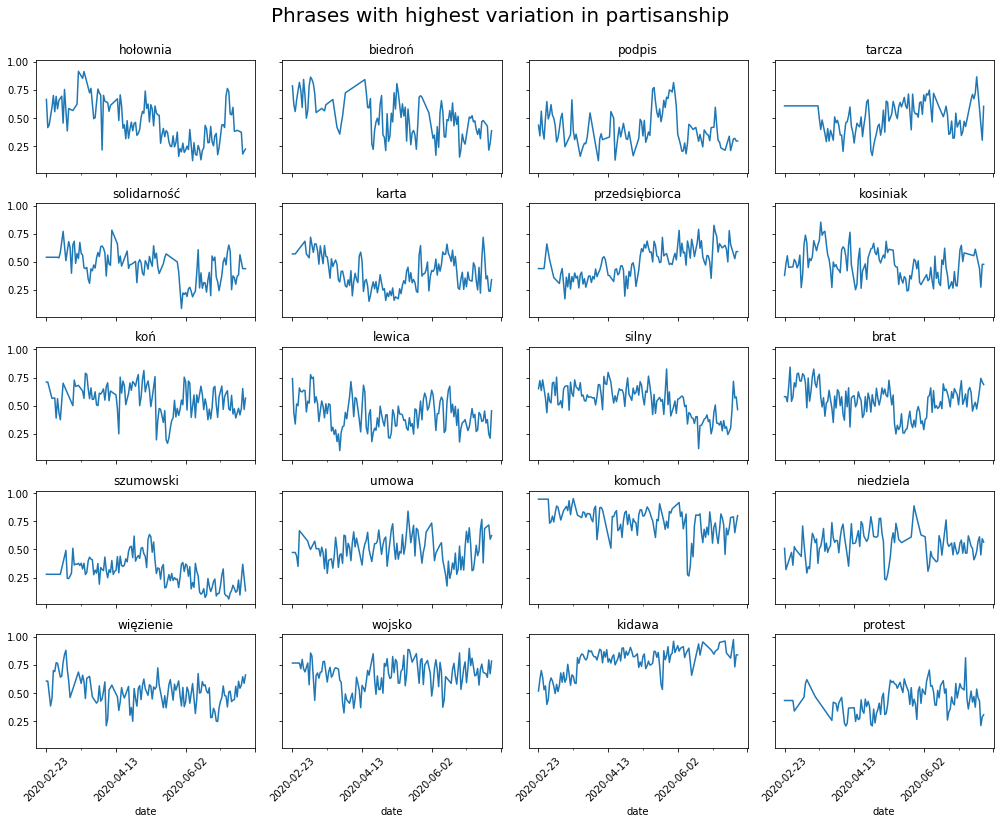

In [15]:
phrases_var = summary[summary.posterior_miss < 40].sort_values(['posterior_sd'], ascending = False).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize = (14, 12), sharex = True, sharey = True)
fig.suptitle('Phrases with highest variation in partisanship', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_var.phrase):
    phrases[phrases.phrase == phr].posterior.interpolate(method = 'linear',limit_direction = 'both').plot(rot = 45, ax = ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### By topic:

In [64]:
PATH_RES = os.path.join(PATH, 'results/polarization/phrase_partisanship_bytopic.csv')
if os.path.isfile(PATH_RES):
    phrases = pd.read_csv(PATH_RES, index_col = 0)
else:
    phrases = dict()
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff)):
        data['topic'] = data['id_str'].map(topic_map).astype(str)
        for topic, dat in data.groupby('topic'):
            parties = dat["source"] #get parties
            users = dat["user-id_str"] #get users 
            tweets = dat["lemmatized"].astype(str) #get tweets
            model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), stop_words = stopwords)
            #get polarization scores:
            post = model.get_posteriors(parties, users, tweets)
            #tokenize:
            tokens = nltk.word_tokenize("\n".join(tweets.tolist()))
            tokens = [w for w in tokens if w in list(model.vectorizer.vocabulary_.keys())] #stopwords and under min_df
            #get bigram counts:
            bgs = nltk.bigrams(tokens)
            counts = nltk.FreqDist(bgs)
            counts = {" ".join(k):v for k, v in counts.items()}
            #and unigram counts:
            counts.update(nltk.FreqDist(tokens))
            day = dat.day.unique()[0]
            for w in post:
                phrases[(day,topic,w)] = {'score':post[w], 'n':counts[w]}
    phrases = pd.DataFrame.from_dict(phrases, orient = 'index')
    phrases.reset_index(inplace = True)
    phrases.columns = ['date','topic','phrase', 'score', 'n']
    phrases.set_index(['topic','phrase'], inplace = True)
    phrases['num_days'] = phrases.groupby(phrases.index).size()
    phrases = phrases.reset_index()
    phrases.to_csv(PATH_RES)

In [68]:
phrase_polarization = phrases[phrases.num_days >= 30].groupby(['topic','phrase']).apply(lambda x: weighted_average(x, 'n')).reset_index()
phrase_polarization.columns = ['topic','phrase','score']

In [113]:
phrase_polarization.topic = phrase_polarization.topic.astype(int)
@interact
def show_articles_more_than(topic = list(sorted(phrase_polarization.topic.unique())), group = ['all', 'government', 'opposition'], topn = 5):
    if group == 'government':
        ind = phrase_polarization['score'].groupby(phrase_polarization['topic']).nlargest(n = topn).index.droplevel(0)
        df = phrase_polarization.iloc[ind]
    elif group == 'opposition':
        ind = phrase_polarization['score'].groupby(phrase_polarization['topic']).nsmallest(n = topn).index.droplevel(0)
        df = phrase_polarization.iloc[ind]
    elif group == 'all':
        df = phrase_polarization
    return df.loc[df['topic'] == topic]

interactive(children=(Dropdown(description='topic', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

## Retweet partisanship

In [122]:
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))

#filter function:
def filter_fun(df:pd.DataFrame, drop_users:list, drop_tweets:list):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets)

### 1. Overall:

In [149]:
%%time
PATH_RESULT = os.path.join(PATH, 'results/polarization/polarization_retweets.csv')
if os.path.isfile(PATH_RESULT):
    retweets = pd.read_csv(PATH_RESULT, index_col = 0)
else:
    retweets = pd.DataFrame(columns = ['full_text', 'source', 'pol', 'day', 'topic', 'num', 'new_num'])
    for dat in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff)):
        
        #obtain topics:
        dat['topic'] = dat['id_str'].map(topic_map).astype(int) 
        
        #obtain polarization:
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        est = model.estimate(dat['source'], dat['user-id_str'], dat['lemmatized'], 
                             text_id = dat['id_str'], level ='speech', leave_out = False)
        dat = dat[dat['retweet']]
        dat['pol'] = dat['id_str'].map(est)
        
        #collapse by text to get counts:
        collapsed = dat.groupby(['full_text','source', 'pol', 'day', 'topic']).size().reset_index()
        
        #rename columns:
        collapsed.columns = ['full_text','source','pol','day','topic', 'num']
        
        #drop those only retweeted once:
        collapsed = collapsed[collapsed['num'] > 1] #more than one retweet to count
        
        #get counts of all tweets as dictionary:
        counts = collapsed[['full_text','num']].set_index('full_text')['num'].to_dict()
        
        #map to the existing dataframe
        retweets['new_num'] = retweets['full_text'].map(counts)
        retweets['num'] += np.nan_to_num(retweets['new_num'], 0)
        del retweets['new_num']
            
        
        #append new tweets to the final data frame  :
        collapsed = collapsed[np.logical_not(collapsed['full_text'].isin(retweets['full_text']))]
        retweets = retweets.append(collapsed)
        
    retweets.to_csv(PATH_RESULT) #save result

KeyboardInterrupt: 

### 2. Day-level

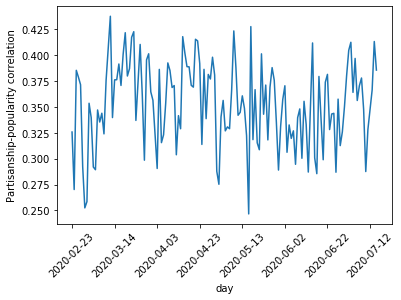

In [37]:
correlations = retweets.groupby(['day']).corr().reset_index()
correlations[correlations['level_1'] == 'pol'].set_index('day')['num'].plot(rot = 45)
plt.ylabel('Partisanship-popularity correlation')
plt.show()

### 3. Week- level:

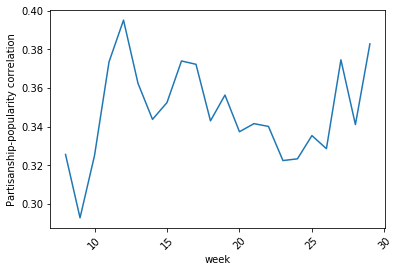

In [36]:
correlations = retweets.groupby(['week']).corr().reset_index()
correlations[correlations['level_1'] == 'pol'].set_index('week')['num'].plot(rot = 45)
plt.ylabel('Partisanship-popularity correlation')
plt.show()

### 4. By topic:

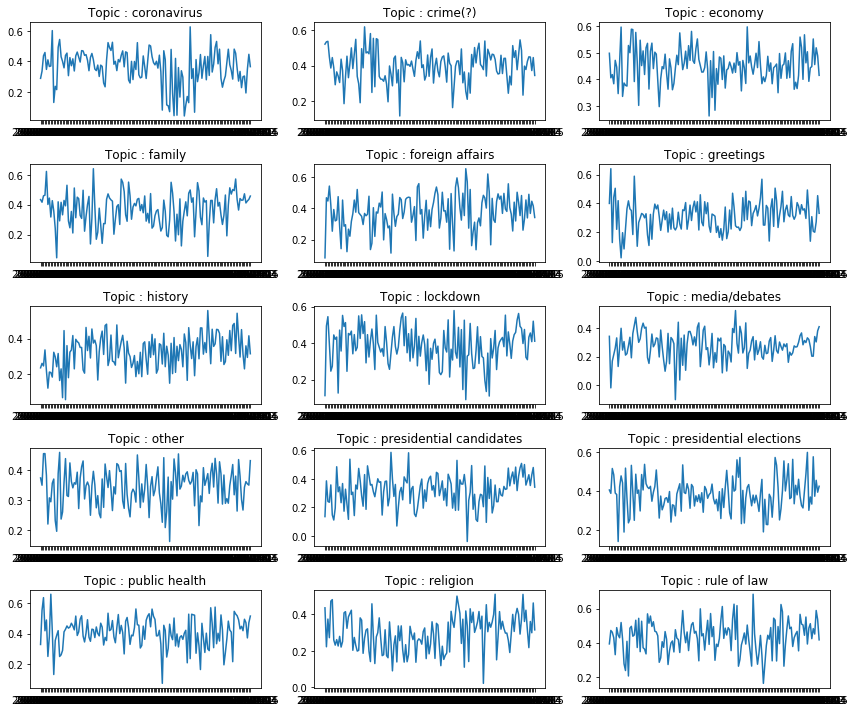

In [58]:
retweets['topic_name'] = retweets['topic'].astype(str).map(topic_dict)
correlations = retweets.groupby(['day', 'topic_name']).corr().reset_index()
correlations = correlations[correlations['level_2'] == 'pol']
fig, ax = plt.subplots(5, 3, figsize = (12, 10))
ax = ax.ravel()
for i, (topic, df) in enumerate(correlations.groupby('topic_name')):
    ax[i].plot(df['day'], df['num'])
    ax[i].set_title(f'Topic : {topic}')
    ax[i].xaxis.set_tick_params(rotation=45)
    ax[i].xaxis.set_ticks(np.arange(len(df['day']), step = 20))
plt.tight_layout()
plt.show()